**BILSTM-CNN ARCH (WORKING)**
# changed scaling to standard also

In [6]:
# Equation Params
sigma = 10
rho = 28
beta = 8/3
initial_conditions = [-5.0, -10.0, 20.0] # initial conditions

# Time Params
t_end = 100                  # t final
t_points = 1000            # points
lyapunov_exponent = 1       # set to 1 to ignore lyapunov

# Split Param
split_ratio = 1/8

# Scaler Params (don't modify unless you know what you are doing)
feature_range = (0, 1)

# Model Hyperparams (don't need to modify unless want to)
lstm_dim = 512
learning_rate = 0.001
epochs = 100
batch_size = 1000

# Params for the iterative forecast 
num_iterations = 1

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from keras.models import Model
from keras.layers import LSTM, Dense, Bidirectional, Input, Conv1D, Flatten, Concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define the Lorenz-63 system
def lorenz63(state, t, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Define time span
t = np.linspace(0, t_end, t_points)

# Compute Lyapunov time
lyapunov_time = 1 / np.abs(lyapunov_exponent)
t_lyapunov = t / lyapunov_time


# Solve Lorenz-63 equations using odeint
solution = odeint(lorenz63, initial_conditions, t_lyapunov, args=(sigma, rho, beta))

# Split solutions into separate variables
solution_x = solution[:, 0].reshape(-1, 1)
solution_y = solution[:, 1].reshape(-1, 1)
solution_z = solution[:, 2].reshape(-1, 1)

# Split data into input and ground truth
points_length = int(len(solution) * split_ratio)
input_solution_x = solution_x[:points_length]
ground_truth_solution_x = solution_x[points_length:]
input_solution_y = solution_y[:points_length]
ground_truth_solution_y = solution_y[points_length:]
input_solution_z = solution_z[:points_length]
ground_truth_solution_z = solution_z[points_length:]

# Scale for each variable
scaler_x = MinMaxScaler(feature_range=feature_range)
scaler_y = MinMaxScaler(feature_range=feature_range)
scaler_z = MinMaxScaler(feature_range=feature_range)

X_train_normalized_x = scaler_x.fit_transform(input_solution_x)
y_train_normalized_x = scaler_x.transform(ground_truth_solution_x)
X_train_normalized_x = np.reshape(X_train_normalized_x, (-1, 1, 1))
y_train_normalized_x = np.reshape(y_train_normalized_x, (-1, 1, 1))

X_train_normalized_y = scaler_y.fit_transform(input_solution_y)
y_train_normalized_y = scaler_y.transform(ground_truth_solution_y)
X_train_normalized_y = np.reshape(X_train_normalized_y, (-1, 1, 1))
y_train_normalized_y = np.reshape(y_train_normalized_y, (-1, 1, 1))

X_train_normalized_z = scaler_z.fit_transform(input_solution_z)
y_train_normalized_z = scaler_z.transform(ground_truth_solution_z)
X_train_normalized_z = np.reshape(X_train_normalized_z, (-1, 1, 1))
y_train_normalized_z = np.reshape(y_train_normalized_z, (-1, 1, 1))


# ---------------------BiLSTM-CNN model----------------------------------------------------------------------------------
def build_bidirectional_lstm_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # CNN branch
    cnn = Conv1D(filters=512, kernel_size=3, activation='relu', padding='same')(inputs)
    cnn = Conv1D(filters=512, kernel_size=3, activation='relu', padding='same')(cnn)
    cnn = Flatten()(cnn)
    
    # Bidirectional LSTM branch
    lstm = Bidirectional(LSTM(lstm_dim, return_sequences=True))(inputs)
    lstm = Bidirectional(LSTM(lstm_dim))(lstm)
    
    # Concatenate the outputs of CNN and bidirectional LSTM branches
    merged = Concatenate()([cnn, lstm])
    
    # Fully connected layers
    merged = Dense(lstm_dim, activation='relu')(merged)
    outputs = Dense(1)(merged)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model_x = build_bidirectional_lstm_cnn_model((X_train_normalized_x.shape[1], 1))
model_y = build_bidirectional_lstm_cnn_model((X_train_normalized_y.shape[1], 1))
model_z = build_bidirectional_lstm_cnn_model((X_train_normalized_z.shape[1], 1))

optimizer_x = Adam(learning_rate=learning_rate)
optimizer_y = Adam(learning_rate=learning_rate)
optimizer_z = Adam(learning_rate=learning_rate)

model_x.compile(optimizer=optimizer_x, loss='mse')
model_y.compile(optimizer=optimizer_y, loss='mse')
model_z.compile(optimizer=optimizer_z, loss='mse')

# fit them 
model_x.fit(X_train_normalized_x, X_train_normalized_x, epochs=epochs, batch_size=batch_size, verbose=1)
model_y.fit(X_train_normalized_y, X_train_normalized_y, epochs=epochs, batch_size=batch_size, verbose=1)
model_z.fit(X_train_normalized_z, X_train_normalized_z, epochs=epochs, batch_size=batch_size, verbose=1)

# predict using the trained models
predicted_solution_normalized_x = model_x.predict(y_train_normalized_x)
predicted_solution_normalized_y = model_y.predict(y_train_normalized_y)
predicted_solution_normalized_z = model_z.predict(y_train_normalized_z)

# back to original scale
predicted_solution_x = scaler_x.inverse_transform(predicted_solution_normalized_x).flatten()
predicted_solution_y = scaler_y.inverse_transform(predicted_solution_normalized_y).flatten()
predicted_solution_z = scaler_z.inverse_transform(predicted_solution_normalized_z).flatten()

# Calculate error
# error = np.mean(np.abs(ground_truth_solution_x - predicted_solution_x))
# print("Error:", error)

# ----------------------------------------------------------------------------------------------

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.2128
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1532
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0951
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0378
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0061
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0327
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0523
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0335
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0112
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0043
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.0098
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0176
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0211
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0194
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0141
Epoch 1

**iterative forecast function (iterates over time span defined by split)**

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 8.8713e-07
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - loss: 7.2467e-07
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 3.5710e-07
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 3.2706e-07
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 5.6734e-07
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 6.1064e-07
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 3.8332e-07
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 2.5070e-07
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 3.6882e-07
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 4.7427e-07
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 3.7348e-07
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 2.3773e-07
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 2.6576e-07
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 3.6076e-07
Epoch 15/100
1/

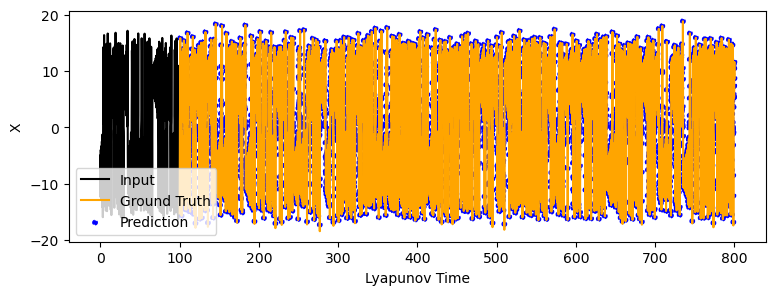

In [8]:
def iterative_forecast(model, initial_input, scaler, num_iterations, split_num, epochs):
    all_predictions = initial_input.copy()  # Make a copy of initial input
    for i in range(num_iterations):
        # define time span
        split_num = int(1/split_num)
        t = np.linspace(0, t_end*split_num**(i+1), t_points*split_num**(i+1))
        t = t / lyapunov_time

        # lorenz solved
        solution = odeint(lorenz63, initial_conditions, t, args=(sigma, rho, beta))
        solution = solution[:, 0].reshape(-1, 1)
        points_length = int(len(solution) * split_ratio)
        input_solution = all_predictions
        ground_truth_solution = solution[points_length:]

        # normalize input data
        input_data_scaled = scaler.fit_transform(input_solution.reshape(-1, 1))
        ground_truth_solution_scaled = scaler.transform(ground_truth_solution.reshape(-1, 1))
        input_data_scaled = np.reshape(input_data_scaled, (-1, 1, 1))
        ground_truth_solution_scaled = np.reshape(ground_truth_solution_scaled, (-1, 1, 1))
    
        # train
        model.fit(input_data_scaled, input_data_scaled, epochs=epochs, batch_size=t_points, verbose=1)

        # predict
        predicted_solution_normalized = model.predict(ground_truth_solution_scaled)

        # back to original
        predicted_solution = scaler.inverse_transform(predicted_solution_normalized).flatten()

        # append
        all_predictions = np.concatenate((all_predictions, predicted_solution.reshape(-1, 1)))

        plt.figure(figsize=(9, 3))
        plt.plot(t[:points_length], input_solution, label='Input', color='black')
        plt.plot(t[points_length:], ground_truth_solution, label='Ground Truth', color='orange')
        plt.scatter(t[points_length:], predicted_solution, label='Prediction', color='blue', linestyle='--', s=10)
        plt.xlabel('Lyapunov Time')
        plt.ylabel('X')
        plt.legend()

# perform recursive prediction for x variable
all_predictions_x = iterative_forecast(model_x, np.concatenate((input_solution_x, predicted_solution_x.reshape(-1, 1))), scaler_x, num_iterations, split_ratio, epochs)

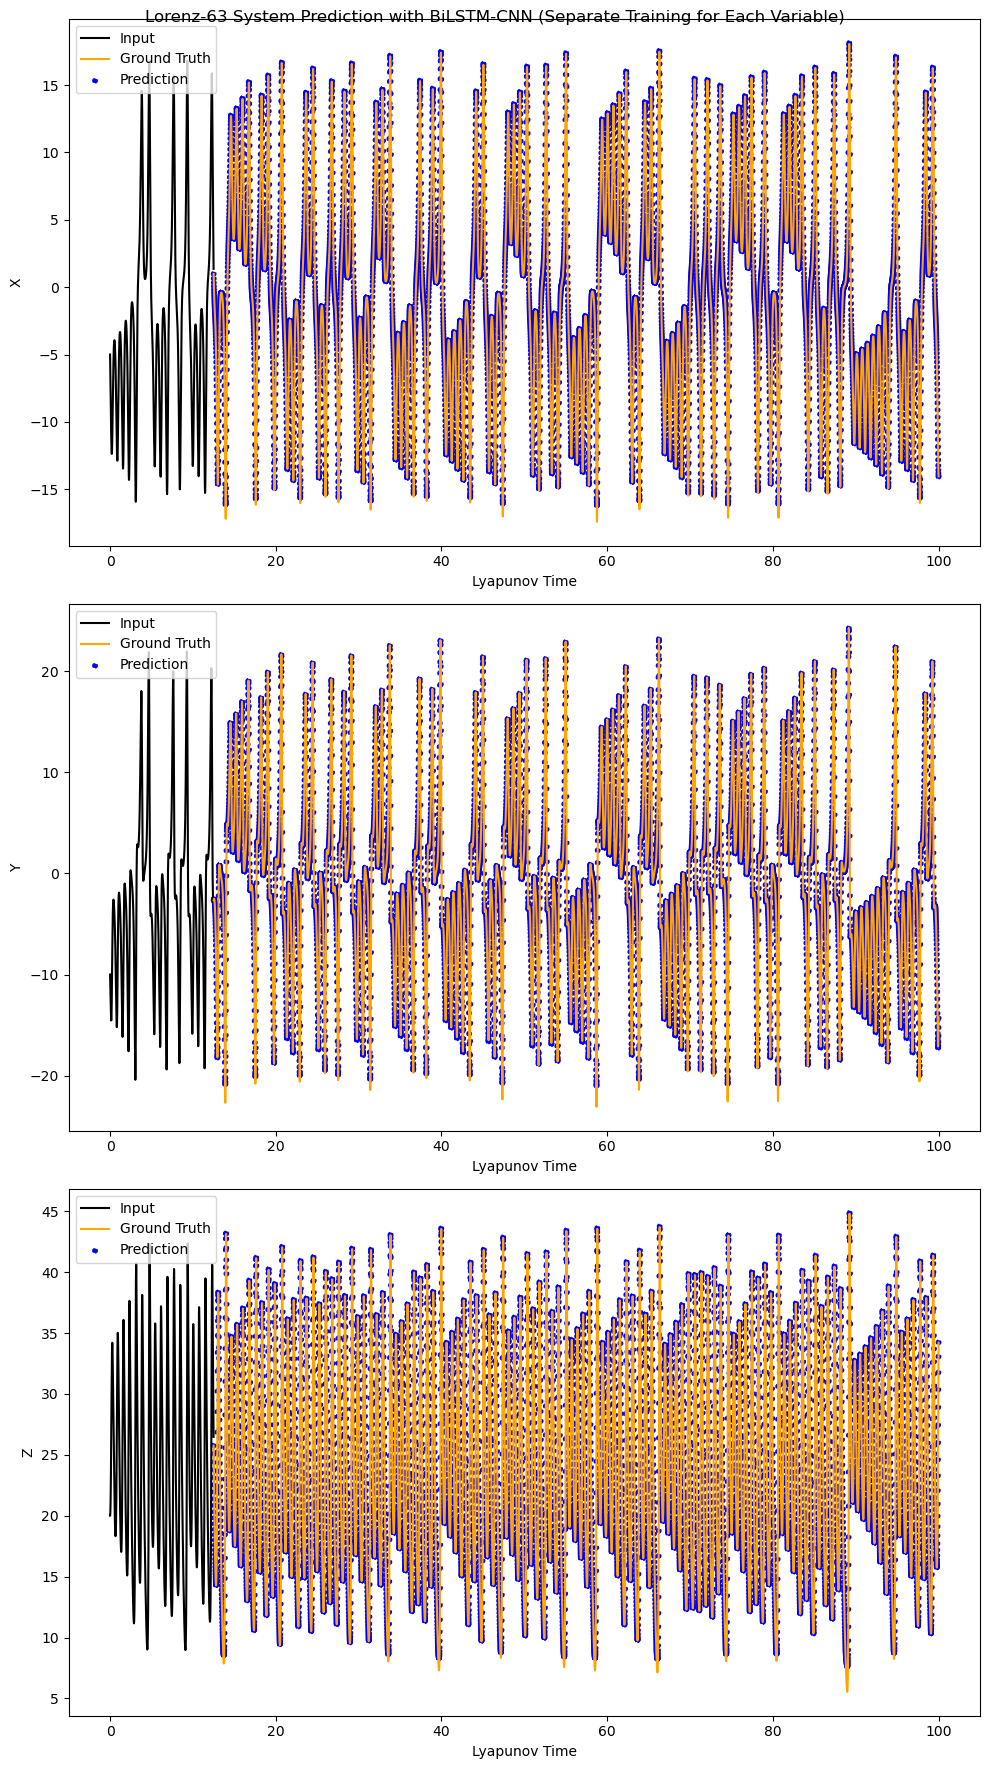

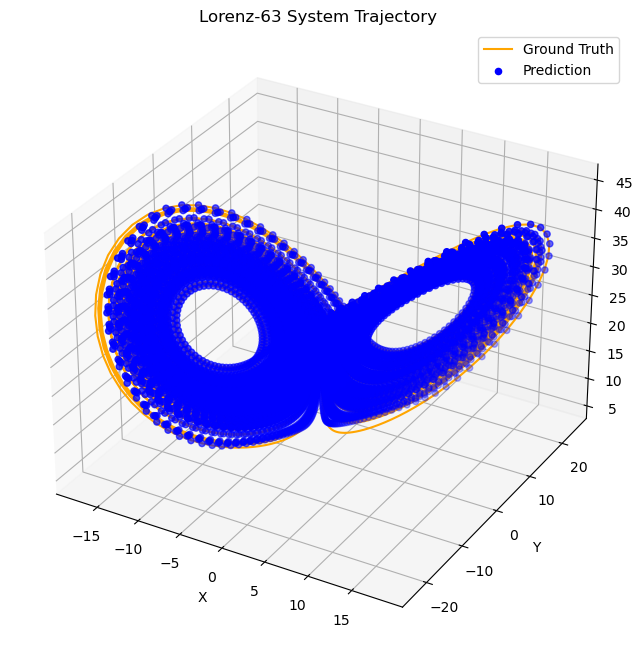

In [3]:
# plot
plt.figure(figsize=(10, 18))

plt.subplot(3, 1, 1)
plt.plot(t_lyapunov[:points_length], input_solution_x, label='Input', color='black')
plt.plot(t_lyapunov[points_length:], ground_truth_solution_x, label='Ground Truth', color='orange')
plt.scatter(t_lyapunov[points_length:], predicted_solution_x, label='Prediction', color='blue', linestyle='--', s=10)
plt.xlabel('Lyapunov Time')
plt.ylabel('X')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_lyapunov[:points_length], input_solution_y, label='Input', color='black')
plt.plot(t_lyapunov[points_length:], ground_truth_solution_y, label='Ground Truth', color='orange')
plt.scatter(t_lyapunov[points_length:], predicted_solution_y, label='Prediction', color='blue', linestyle='--', s=10)
plt.xlabel('Lyapunov Time')
plt.ylabel('Y')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_lyapunov[:points_length], input_solution_z, label='Input', color='black')
plt.plot(t_lyapunov[points_length:], ground_truth_solution_z, label='Ground Truth', color='orange')
plt.scatter(t_lyapunov[points_length:], predicted_solution_z, label='Prediction', color='blue', linestyle='--', s=10)
plt.xlabel('Lyapunov Time')
plt.ylabel('Z')
plt.legend()

plt.suptitle('Lorenz-63 System Prediction with BiLSTM-CNN (Separate Training for Each Variable)')
plt.tight_layout()

# 3d model
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# ground truth trajectory
ax.plot(solution_x.flatten(), solution_y.flatten(), solution_z.flatten(), label='Ground Truth', color='orange')

# prediction
ax.scatter(predicted_solution_x, predicted_solution_y, predicted_solution_z, label='Prediction', color='blue')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz-63 System Trajectory')

plt.legend()
plt.show()
